In [1]:
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
from sklearn import metrics
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
import scipy
import numpy as np
import csv

Анализ данных
--
Выборку я просмотрела в экселе, так что уже имею некоторые представление о данных с короторыми
придется работать. 
Перед нами стоит задача прогнозирования оттока клиентов. Необходимо предстказать будет ли клиент пролонгировть 
страховой полис, или нет. Тогда, другими словами, перед нами стоит задача бинарной классификации, где
- 0 клиент не пролонгирует полис
- 1 клиент пролонгирует полис

In [34]:
df = pd.read_csv('Data.txt', delimiter  = ';')

Смотрим на наши данные. Для обучения моделей из sklearn необходимо привести все данные к числовому формату. 
У нас имеются некоторые данные в формате object, будем работать с ними

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96605 entries, 0 to 96604
Data columns (total 30 columns):
DATA_TYPE                        96605 non-null object
POLICY_ID                        96605 non-null int64
POLICY_BEGIN_MONTH               96605 non-null int64
POLICY_END_MONTH                 96605 non-null int64
POLICY_IS_RENEWED                96605 non-null int64
POLICY_SALES_CHANNEL             96605 non-null int64
POLICY_SALES_CHANNEL_GROUP       96605 non-null int64
POLICY_BRANCH                    96605 non-null object
POLICY_MIN_AGE                   96605 non-null int64
POLICY_MIN_DRIVING_EXPERIENCE    96605 non-null int64
VEHICLE_MAKE                     96605 non-null object
VEHICLE_MODEL                    96605 non-null object
VEHICLE_ENGINE_POWER             96605 non-null float64
VEHICLE_IN_CREDIT                96605 non-null int64
VEHICLE_SUM_INSURED              96605 non-null float64
POLICY_INTERMEDIARY              96605 non-null object
INSURER_GENDER    

Наибольшие трудности возникают с категориальными признаками, так как это как правило строковые выражения, с которыми не работают модели

In [4]:
def find_cat(data):
    for name in data.columns:
        s = ''
        s += name
        if type(data[name][0]) == str:
            s += ' string,'
            print (s)
            print (data[name].nunique())
            print (data[name].unique())
            
find_cat(df)

DATA_TYPE string,
2
['TRAIN' 'TEST ']
POLICY_BRANCH string,
2
['Москва' 'Санкт-Петербург']
VEHICLE_MAKE string,
83
['Land Rover' 'Opel' 'Kia' 'Citroen' 'Renault' 'Suzuki' 'Hyundai' 'BMW'
 'Skoda' 'Volkswagen' 'Ssang Yong' 'Toyota' 'Ford' 'Fiat' 'Honda' 'Mazda'
 'Mitsubishi' 'Peugeot' 'Nissan' 'ГАЗ' 'Dodge' 'Lifan' 'Audi' 'УАЗ'
 'Volvo' 'Porsche' 'Subaru' 'ВАЗ' 'Chevrolet' 'Daewoo' 'Lada'
 'Mercedes-Benz' 'Lexus' 'Другая марка (Иностранного производства)' 'Seat'
 'Jeep' 'Infiniti' 'Acura' 'Mini'
 'Другая марка (Отечественного производства)' 'Geely' 'Great Wall'
 'Datsun' 'Chrysler' 'Chery' 'Cadillac' 'Jaguar' 'Smart' 'Tagaz' 'Vortex'
 'Brilliance' 'КАМАЗ' 'Saab' 'Scania' 'Wielton' 'Faw' 'Hummer' 'Daihatsu'
 'Changan' 'MAN' 'DAF' 'BYD' 'Lincoln' 'Alfa Romeo' 'Bogdan' 'Maserati'
 'Haima' 'Scion' 'Jcb' 'Купава' 'Rolls-Royce' 'Rover' 'ПАЗ' 'Bentley'
 'Ferrari' 'ИПВ' 'Iveco' 'Kogel' 'ИЖ' 'Krone' 'Hafei' '<Пусто>' 'МАЗ']
VEHICLE_MODEL string,
549
['Discovery' 'Zafira' 'Soul' 'C-Crosser' 'Loga

Видим, что у нас имеется два категориальных признака - **POLICY_BRANCH**  и **INSURER_GENDER** , 
которые можно закодировать как бинарные

In [5]:
df['POLICY_BRANCH'] = [0 if (x == 'Москва') else 1 for x in df['POLICY_BRANCH'].values]
df['INSURER_GENDER'] = [0 if (x == 'M') else 1 for x in df['INSURER_GENDER'].values]

Закодируем другие признаки. Для последующего применения методов KKN и dessision tree 
Я не выбираю one-hot кодлирование, а кодирую признаки на основании другого. В данном случае целевого признака.
Т.е. например, - вместо VEHICLE_MAKE я напишу % того, сколько владельцев машин из конктреной котегории
VEHICLE_MAKE имеют POLICY_IS_RENEWED == 1. Или, вероятность того, что владелец машины с таким двигателем продлевал полис

In [6]:
def code_mean(data, cat_feature, real_feature):
    data_train = data[data['DATA_TYPE']=='TRAIN']
    return (data[cat_feature].map(data_train.groupby(cat_feature)[real_feature].mean()))

df['VEHICLE_MAKE'] = code_mean(df, 'VEHICLE_MAKE', 'POLICY_IS_RENEWED')
df['VEHICLE_MODEL'] = code_mean(df, 'VEHICLE_MODEL', 'POLICY_IS_RENEWED')
df['POLICY_CLM_N'] = code_mean(df, 'POLICY_CLM_N', 'POLICY_IS_RENEWED')
df['POLICY_CLM_GLT_N'] = code_mean(df, 'POLICY_CLM_GLT_N', 'POLICY_IS_RENEWED')
df['POLICY_PRV_CLM_N'] = code_mean(df, 'POLICY_PRV_CLM_N', 'POLICY_IS_RENEWED')
df['POLICY_PRV_CLM_GLT_N'] = code_mean(df, 'POLICY_PRV_CLM_GLT_N', 'POLICY_IS_RENEWED')
df['CLIENT_REGISTRATION_REGION'] = code_mean(df, 'CLIENT_REGISTRATION_REGION', 'POLICY_IS_RENEWED')
df['POLICY_INTERMEDIARY'] = code_mean(df, 'POLICY_INTERMEDIARY', 'POLICY_IS_RENEWED')
df['POLICY_YEARS_RENEWED_N'] = code_mean(df, 'POLICY_YEARS_RENEWED_N', 'POLICY_IS_RENEWED')

In [7]:
pd.set_option('display.max_columns', None)
df

,DATA_TYPE,POLICY_ID,POLICY_BEGIN_MONTH,POLICY_END_MONTH,POLICY_IS_RENEWED,POLICY_SALES_CHANNEL,POLICY_SALES_CHANNEL_GROUP,POLICY_BRANCH,POLICY_MIN_AGE,POLICY_MIN_DRIVING_EXPERIENCE,VEHICLE_MAKE,VEHICLE_MODEL,VEHICLE_ENGINE_POWER,VEHICLE_IN_CREDIT,VEHICLE_SUM_INSURED,POLICY_INTERMEDIARY,INSURER_GENDER,POLICY_CLM_N,POLICY_CLM_GLT_N,POLICY_PRV_CLM_N,POLICY_PRV_CLM_GLT_N,CLIENT_HAS_DAGO,CLIENT_HAS_OSAGO,POLICY_COURT_SIGN,CLAIM_AVG_ACC_ST_PRD,POLICY_HAS_COMPLAINTS,POLICY_YEARS_RENEWED_N,POLICY_DEDUCT_VALUE,CLIENT_REGISTRATION_REGION,POLICY_PRICE_CHANGE
0,TRAIN,1,1,1,1,39,1,0,51,12,0.644825,0.629630,245.0,0,1283202.0,0.600000,1,0.663699,0.666753,0.531372,0.531372,1,0,0,0.0,0,0.530975,0.0,0.452514,-1.00
1,TRAIN,2,1,1,1,50,5,0,35,7,0.635540,0.643836,140.0,0,453000.0,0.680812,0,0.663699,0.666753,0.681596,0.682647,1,1,0,0.0,0,0.676108,0.0,0.608957,-0.05
2,TRAIN,3,1,1,1,52,6,0,41,6,0.628763,0.677291,129.0,0,647718.0,0.680812,1,0.663699,0.666753,0.686841,0.668052,0,0,0,0.0,0,0.674547,12518.0,0.552106,-0.07
3,TRAIN,4,1,1,1,50,5,0,36,12,0.635688,0.666667,170.0,0,757795.0,0.680812,0,0.663699,0.666753,0.681596,0.682647,1,1,0,0.0,0,0.732950,15000.0,0.608957,0.05
4,TRAIN,5,1,1,0,52,6,1,42,5,0.642054,0.635200,102.0,0,604500.0,0.666034,1,0.663699,0.666753,0.531372,0.531372,0,0,0,0.0,0,0.530975,50000.0,0.605579,0.17
5,TRAIN,6,2,1,1,2,4,1,60,40,0.639876,0.661220,140.0,0,535815.0,0.722772,0,0.663699,0.666753,0.681596,0.682647,0,0,0,0.0,0,0.681352,7500.0,0.683106,-0.02
6,TRAIN,7,1,1,1,52,6,0,41,6,0.628763,0.637555,175.0,0,1696400.0,0.498333,1,0.663699,0.666753,0.531372,0.531372,0,0,0,0.0,0,0.530975,0.0,0.608957,-0.23
7,TRAIN,8,2,2,1,10,1,1,48,19,0.624473,0.648253,197.0,0,1063317.0,0.750000,0,0.663699,0.666753,0.681596,0.682647,1,1,0,0.0,0,0.681352,0.0,0.683106,0.04
8,TRAIN,9,1,1,0,53,6,0,27,7,0.569617,0.627490,245.0,0,2248000.0,0.393665,1,0.596433,0.587450,0.531372,0.531372,0,0,0,4.0,0,0.530975,0.0,0.608957,-1.00
9,TEST,10,2,2,0,53,6,1,56,37,0.647330,0.619835,102.0,0,480930.0,0.643478,0,0.663699,0.666753,0.681596,0.682647,0,1,0,0.0,0,0.674547,15000.0,0.683106,-0.04


В признаке POLICY_MIN_DRIVING_EXPERIENCE имеются ошибки заполнения, которые нужно поправить. Дата создания 
txt файла с данными 2016 год так что смело предположим, что можно вычислить опыт вождения от этой даты

In [8]:
df['POLICY_MIN_DRIVING_EXPERIENCE'] = [
    x if (x < 100) 
    else (2016-x) 
    for x in df['POLICY_MIN_DRIVING_EXPERIENCE'].values]

При помощи функции из документации matplotlib построим диагональное поле корреляций и оценим уровень свзи признаков с целевым

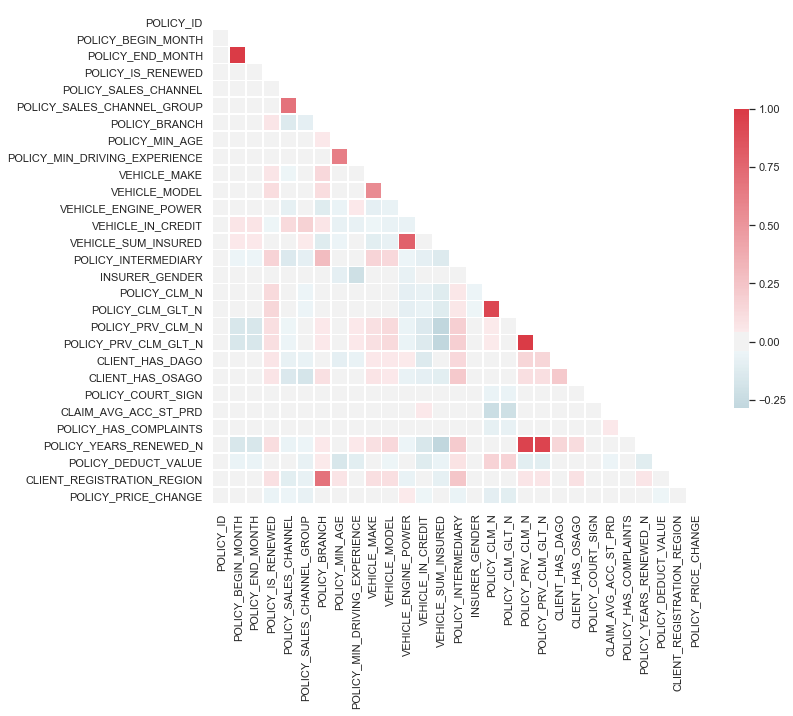

In [17]:
from string import ascii_letters
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 11))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.6, cbar_kws={"shrink": .5})

Видим по матрице кореляций, что некоторые данные имеют корреляцию друг с другом. 
**Мультиколлениальность** имеет серьезное последсвие - конкретные результаты оценки могут сильно различаться 
для разных выборок несмотря на то, что выборки однородны. Значит по факту наша модель будет не применима на новх признаках. Поэтому уберем их и оставим значимыем (с корреляцией от 0.1) для целевого признака.

На самом деле уровень кореляции считается сильным/значемым в диапазоне от 0.7 до 0.9 . Но на данной выборке такие коэфиценты редко встречаются, и ,относительно других значений, коэфицент = 0.1 считается довльно значимым

In [19]:
features = ['DATA_TYPE', 'POLICY_ID', 'POLICY_IS_RENEWED', 'POLICY_INTERMEDIARY', 'VEHICLE_MODEL', 
            'POLICY_CLM_GLT_N', 'CLIENT_HAS_DAGO', 'CLIENT_HAS_OSAGO', 'POLICY_YEARS_RENEWED_N',  
           'CLIENT_REGISTRATION_REGION', 'POLICY_MIN_DRIVING_EXPERIENCE']
data_set = df[features]

In [20]:
data_set.corr('pearson')

,POLICY_ID,POLICY_IS_RENEWED,POLICY_INTERMEDIARY,VEHICLE_MODEL,POLICY_CLM_GLT_N,CLIENT_HAS_DAGO,CLIENT_HAS_OSAGO,POLICY_YEARS_RENEWED_N,CLIENT_REGISTRATION_REGION,POLICY_MIN_DRIVING_EXPERIENCE
POLICY_ID,1.000000,-0.013142,0.002272,-0.001981,-0.011676,0.001770,0.002961,-0.002514,-0.001070,0.003824
POLICY_IS_RENEWED,-0.013142,1.000000,0.171251,0.114697,0.147259,0.063095,0.074351,0.113101,0.093558,0.013354
POLICY_INTERMEDIARY,0.002272,0.171251,1.000000,0.142381,0.060061,0.139198,0.227317,0.205722,0.241905,-0.013213
VEHICLE_MODEL,-0.001981,0.114697,0.142381,1.000000,0.032809,0.056037,0.048550,0.137632,0.104378,0.004543
POLICY_CLM_GLT_N,-0.011676,0.147259,0.060061,0.032809,1.000000,0.008846,0.036533,0.031377,0.041008,0.031763
CLIENT_HAS_DAGO,0.001770,0.063095,0.139198,0.056037,0.008846,1.000000,0.219286,0.157308,0.020608,-0.067522
CLIENT_HAS_OSAGO,0.002961,0.074351,0.227317,0.048550,0.036533,0.219286,1.000000,0.118625,0.090502,-0.006934
POLICY_YEARS_RENEWED_N,-0.002514,0.113101,0.205722,0.137632,0.031377,0.157308,0.118625,1.000000,0.070935,0.048656
CLIENT_REGISTRATION_REGION,-0.001070,0.093558,0.241905,0.104378,0.041008,0.020608,0.090502,0.070935,1.000000,0.034387
POLICY_MIN_DRIVING_EXPERIENCE,0.003824,0.013354,-0.013213,0.004543,0.031763,-0.067522,-0.006934,0.048656,0.034387,1.000000


Посмтрим выборку на нулевые значения. Модель логорифимической регрессии не может принимать в качесве параметра признаки с нулевым значением

In [21]:
data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96605 entries, 0 to 96604
Data columns (total 11 columns):
DATA_TYPE                        96605 non-null object
POLICY_ID                        96605 non-null int64
POLICY_IS_RENEWED                96605 non-null int64
POLICY_INTERMEDIARY              96529 non-null float64
VEHICLE_MODEL                    96575 non-null float64
POLICY_CLM_GLT_N                 96605 non-null float64
CLIENT_HAS_DAGO                  96605 non-null int64
CLIENT_HAS_OSAGO                 96605 non-null int64
POLICY_YEARS_RENEWED_N           96605 non-null float64
CLIENT_REGISTRATION_REGION       96602 non-null float64
POLICY_MIN_DRIVING_EXPERIENCE    96605 non-null int64
dtypes: float64(5), int64(5), object(1)
memory usage: 7.7+ MB


In [22]:
data_set.to_csv('data_set.csv')

In [23]:
data = pd.read_csv('data_set.csv')
data['VEHICLE_MODEL']=data['VEHICLE_MODEL'].fillna(0)
data['POLICY_INTERMEDIARY']=data['POLICY_INTERMEDIARY'].fillna(0)
data['CLIENT_REGISTRATION_REGION']=data['CLIENT_REGISTRATION_REGION'].fillna(0)

Обучение модели
--------------
Поработав с данными и выделив для себя значимые признаки, мы разобьём выборку на тренировочную и тестовую

In [24]:
train_df = data[data['DATA_TYPE']=='TRAIN'].drop('DATA_TYPE', axis=1)
X_train = train_df.drop('POLICY_IS_RENEWED', axis=1)
y_train = train_df['POLICY_IS_RENEWED']
test_df = data[data['DATA_TYPE']=='TEST '].drop('DATA_TYPE', axis=1)
X_test = test_df.drop('POLICY_IS_RENEWED', axis=1)

Разобьём тренировочную выборку на тренировочную и валидационную

In [25]:
X_train_2, X_valid, y_train_2, y_valid = train_test_split(X_train, y_train,  test_size = 0.3, random_state = 1)

Выбор метрики качества. Существует достаточно подробная статья на эту [тему](https://habr.com/company/ods/blog/328372/).
Воспользуемся мерой **accuracy**, так как при методологии определения победителя максимизируются величины TP+TN. Для кроссвалидации воспользуемся StratifiedShuffleSplit, так как функция позволяет проверять классификацию на несбалансированных данных, за счет того, что она возвращает перемешенные случайным образом данные, но при этом в выборках всегда имеется исходное соотношение классов.

In [26]:
sss = StratifiedShuffleSplit(n_splits = 5, random_state = 1)

In [27]:
lr = LogisticRegression(random_state = 1)
print(cross_val_score(lr, X_train_2, y_train_2, scoring='accuracy', cv=sss).mean())

0.6252076028787599


Гиперпараметры для RandomForestClassifier и GradientBoostingClassifier подбирала методом подбора. В итоговое решение вставила гиперпараметры, которые дали наиболее высокий результат при обучении

In [28]:
alg_frst = RandomForestClassifier(random_state=1, n_estimators=400, min_samples_split=8, min_samples_leaf=2)
print(cross_val_score(alg_frst, X_train_2, y_train_2, scoring='accuracy', cv=sss).mean())

0.6727071415390293


In [29]:
gb = GradientBoostingClassifier(random_state = 1, n_estimators = 200, min_samples_leaf = 1, max_depth = 3,
                                max_features =1)
print(cross_val_score(gb, X_train_2, y_train_2, scoring='accuracy', cv=sss).mean())

0.6807529064403026


Обучим на валидационной выборке выбранные модели. Видим, что переобучения не произошло и score примерно совпадает с кроссвалидацией 

In [30]:
lr.fit(X_train_2, y_train_2)
print("lr: ", lr.score(X_valid, y_valid))
alg_frst.fit(X_train_2, y_train_2)
print("rf: ", alg_frst.score(X_valid, y_valid))
gb.fit(X_train_2, y_train_2)
print("gb: ", gb.score(X_valid, y_valid))

lr:  0.6241656977995952
rf:  0.6711019248159152
gb:  0.6776902209016923


Как можно видеть, наиболее высокий результат дает градиентный бустинг.
Обучим модель на тестовых данных и запишем ответ.

In [31]:
prediction = gb.predict(X_test)
prediction_df = {'POLICY_ID': X_test['POLICY_ID'],'POLICY_IS_RENEWED': prediction}
answer = pd.DataFrame(prediction_df)
answer.head()
answer.to_csv('answer.csv',index=False)